Guide to adding layers

In [ ]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(256, 256,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
print(model.summary())

In [1]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
BASE_DIR = 'Chosen class balanced/'
names = ["Cardboard boxes","Cardboard drinks","glass","Metal cans","Metal foils and container","paper","Plastic bottles"]

tf.random.set_seed(1)

In [5]:
# Reorganize the folder structure:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [6]:
# Moce the image files
orig_folders =["Cardboard boxes/","Cardboard drinks/","glass/","Metal cans/","Metal foils and container/","paper/","Plastic bottles/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5) #set 60% for training
    n_valid = int((number_of_images*0.25) + 0.5) #set 25% for validation
    n_test = number_of_images - n_train - n_valid #set 15% for test
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

403 242 101 60
501 301 125 75
410 246 103 61
594 356 149 89
482 289 121 72
137 82 34 21


In [3]:
# get the preprocessing function of this model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
# Generate batches of tensor image data with real-time data augmentation.

train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'Chosen class balanced/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'Chosen class balanced/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'Chosen class balanced/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=1,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

In [5]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

# try out different ones, e.g. MobileNetV2
#tl_model = tf.keras.applications.MobileNetV2()
#print(type(tl_model))
#tl_model.summary()

<class 'keras.src.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool

In [6]:
# convert to Sequential model, omit the last layer
# this works with VGG16 because the structure is linear
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [8]:
# set trainable=False for all layers
# we don't want to train them again
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [9]:
# add a last classification layer for our use case with 5 classes
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(30,activation='relu'))
model.add(layers.Dense(7))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [11]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [12]:
epochs = 30

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=2,
    start_from_epoch=0
)

model.fit(train_batches, validation_data=val_batches,
            callbacks=[early_stopping],
          epochs=epochs, verbose=1)

Epoch 1/30
 55/525 [==>...........................] - ETA: 3:12 - loss: 1.2445 - accuracy: 0.5682

C:\Users\Amirul\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


525/525 [==============================] - 336s 640ms/step - loss: 0.5837 - accuracy: 0.7952 - val_loss: 0.6411 - val_accuracy: 0.8446
Epoch 2/30
525/525 [==============================] - 347s 661ms/step - loss: 0.2573 - accuracy: 0.9138 - val_loss: 0.8103 - val_accuracy: 0.8514
Epoch 3/30
525/525 [==============================] - 351s 668ms/step - loss: 0.1651 - accuracy: 0.9429 - val_loss: 1.0471 - val_accuracy: 0.8251
Epoch 4/30
525/525 [==============================] - 352s 670ms/step - loss: 0.0817 - accuracy: 0.9752 - val_loss: 0.7190 - val_accuracy: 0.8811
Epoch 5/30
525/525 [==============================] - 365s 695ms/step - loss: 0.0911 - accuracy: 0.9686 - val_loss: 0.8207 - val_accuracy: 0.8663
Epoch 6/30
525/525 [==============================] - 372s 709ms/step - loss: 0.0919 - accuracy: 0.9724 - val_loss: 0.9446 - val_accuracy: 0.8377
Epoch 6: early stopping


In [15]:
model.evaluate(test_batches, verbose=1)

525/525 [==============================] - 74s 140ms/step - loss: 0.6981 - accuracy: 0.7905


[0.6980946063995361, 0.7904762029647827]

In [16]:
model.save("VGG16_64relu_30relu_7L_BD500.keras") #saving trained model

In [17]:
loadmodel=tf.keras.models.load_model("VGG16_64relu_30relu_7L_BD500.keras") #to load a different model that has been used before`

In [18]:
# make some predictions
predictions = loadmodel.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

525/525 [==============================] - 74s 140ms/step


making confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
import seaborn as sns

Classes = ["Cardboard boxes","Cardboard drinks","glass","Metal cans","Metal foils and container","paper","Plastic bottles"]


def plot2(y_actual,y_true):

    column=[f'Predicted {label}'for label in Classes]
    indices=[f'Actual {label}' for label in Classes]
    table=pd.DataFrame(confusion_matrix(y_actual,y_result),
                       columns=column,index=indices)

    
    return sns.heatmap(table,annot=True,fmt='d',cmap='Blues') 
    
y_actual=test_batches.labels
y_result=labels

<Axes: >

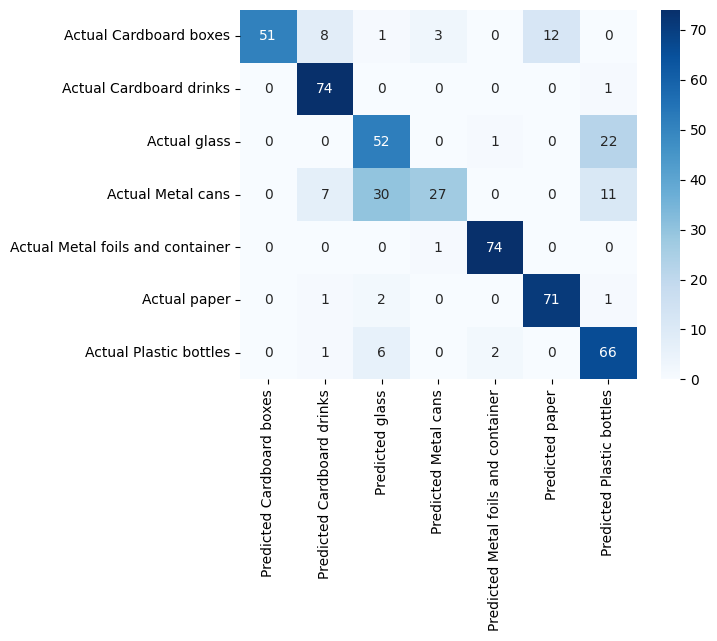

In [20]:
plot2(y_actual,y_result)

In [21]:
#Confusion matrix report

matrix=classification_report(y_actual,y_result)
print('Classification report: \n',matrix)

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.68      0.81        75
           1       0.81      0.99      0.89        75
           2       0.57      0.69      0.63        75
           3       0.87      0.36      0.51        75
           4       0.96      0.99      0.97        75
           5       0.86      0.95      0.90        75
           6       0.65      0.88      0.75        75

    accuracy                           0.79       525
   macro avg       0.82      0.79      0.78       525
weighted avg       0.82      0.79      0.78       525



In [22]:
modelname='VGG16_64relu_30relu_7L_BD500_summary.txt'
def myprint(s):
    with open(modelname,'a') as f:
        print(s, file=f)

loadmodel.summary(print_fn=myprint)

file2write=open(modelname,'a')
file2write.write(matrix)
file2write.close()

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_actual,y_result)

# Labeling the rows and columns
classes = ["0","1","2","3","4","5","6"]
conf_matrix_labeled = np.vstack((np.array([""] + classes), np.column_stack((np.array(classes), conf_matrix))))

# Convert the confusion matrix to a formatted string
conf_matrix_text = "Confusion Matrix:\n" + str(conf_matrix)

# Specify the path of the summary text file
summary_file_path = modelname

# Read the content of the summary file
with open(summary_file_path, 'r') as summary_file:
    summary_content = summary_file.read()
additional_text = "\nClasses :\n Cardboard boxes=0\n Cardboard drinks=1\n glass=2\n Metal cans=3\n Metal foils and container=4\n paper=5\n Plastic bottles=6"
# Append the confusion matrix content to the summary content
combined_content = summary_content + '\n\n' + conf_matrix_text + '\n\n'+additional_text

# Write the combined content back to the summary file
with open(summary_file_path, 'w') as summary_file:
    summary_file.write(combined_content)

print(f"Confusion matrix added to {summary_file_path}")

Confusion matrix added to VGG16_64relu_30relu_7L_BD500_summary.txt
